# Imports

In [23]:
import os
import sys
import h5py
import time
import youtube_dl

import numpy as np
import pandas as pd

import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import YouTubeVideo, Markdown, display, Video, Image

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
sys.path.append('/Users/staveshemesh/Projects/shstav2/token_voken/src')
sys.path.append('/Users/staveshemesh/Projects/shstav2/token_voken')

In [3]:
pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{:,.2f}'.format

# Constants

In [4]:
FRAME_RATE = 15
SPEAKER_NAME = 'oliver'

DATA_ROOT = '/Users/staveshemesh/Projects/PATS_DATA/'
SPEAKER_DATA_DIR = os.path.join(DATA_ROOT, f'Processed/{SPEAKER_NAME}/data')

# All Intervals Raw Data
INTERVALS_FILE_NAME = 'cmu_intervals_df.csv'
INTERVALS_PATH = os.path.join(SPEAKER_DATA_DIR, INTERVALS_FILE_NAME)

# Speaker Data
# /Users/staveshemesh/Projects/PATS_DATA/Processed/oliver/data/processed/oliver/ {100905.h5, 217103.h5}
SPEAKER_PATS_INTERVAL_DIR = os.path.join(DATA_ROOT, f'Processed/{SPEAKER_NAME}/data/processed/{SPEAKER_NAME}')
SPEAKER_YOUTUBE_DATA_DIR = os.path.join(DATA_ROOT, f'Youtube/{SPEAKER_NAME}/')

# Processed Data
INTERVALS_PATH_CACHE = os.path.join(DATA_ROOT, 'Sample/df_intervals_all.csv')

In [5]:
TIMESTR = time.strftime("%Y%m%d_%H%M%S")

OUTPUT_ROOT = '/Users/staveshemesh/Projects/shstav2/token_voken/data/'
OUTPUT_DIR = os.path.join(OUTPUT_ROOT, TIMESTR, 'dataframes')

In [6]:
LIST_BULLET = '  ◘ '
TAB = '&nbsp;&nbsp;&nbsp;&nbsp;'
VIDEO_ID_LEN = 11

# Helpers

## Resolvers

In [7]:
from src.path_resolvers import *

## Data Processing

In [8]:
def read_text(interval_id, debug=False):
    interval_text_path = resolve_interval_text_path(interval_id)
    if debug:
        print('resolve_interval_text_path: ', interval_text_path)
    df_token_frames_interval = pd.read_hdf(interval_text_path)
    df_token_frames_interval['start_frame'] = df_token_frames_interval['start_frame'].astype(int)
    df_token_frames_interval['end_frame'] = df_token_frames_interval['end_frame'].astype(int)
    df_token_frames_interval['frames_count'] = df_token_frames_interval['end_frame'] - df_token_frames_interval['start_frame']
    df_token_frames_interval['time'] = round(df_token_frames_interval['end_frame'] / FRAME_RATE, 1)
    return df_token_frames_interval

In [9]:
def process_intervals(df_intervals_all):
    df_intervals_all['org_start_time'] = df_intervals_all['start_time']
    df_intervals_all['org_end_time'] = df_intervals_all['end_time']

    df_intervals_all['start_time'] = pd.to_timedelta(df_intervals_all['start_time'].str.slice(11, 22))
    df_intervals_all['end_time'] = pd.to_timedelta(df_intervals_all['end_time'].str.slice(11, 22))

    time_format_func = lambda x: f'{x.components.hours:02d}:{x.components.minutes:02d}:{x.components.seconds:02d}.{x.components.milliseconds//10}' if not pd.isnull(x) else ''
    df_intervals_all['start_time_string'] = df_intervals_all['start_time'].apply(time_format_func)
    df_intervals_all['end_time_string'] = df_intervals_all['end_time'].apply(time_format_func)
    
    df_intervals_all['video_id'] = df_intervals_all['video_link'].str.slice(start=-VIDEO_ID_LEN)

## Run Commands

In [10]:
from src.commands import run_command

## Display Utils

In [11]:
from src.display_utils import *

# Read Data

In [18]:
!ls -al {PATS_SPEAKER_DATA_DIR}

total 366720
drwxr-xr-x@ 7 staveshemesh  staff        224 Apr 20 12:07 .
drwxr-xr-x@ 4 staveshemesh  staff        128 Apr 20 12:07 ..
-rw-r--r--@ 1 staveshemesh  staff       6148 Apr 20 12:07 .DS_Store
-rw-rw-r--@ 1 staveshemesh  staff   16269612 Aug 24  2020 cmu_intervals_df.csv
-rw-rw-r--@ 1 staveshemesh  staff     505427 Aug 24  2020 cmu_intervals_df_transforms.csv
-rw-rw-r--@ 1 staveshemesh  staff  170969952 Aug 24  2020 missing_intervals.h5
drwxr-xr-x@ 4 staveshemesh  staff        128 Mar  7 13:41 processed


In [17]:
! echo {PATS_SPEAKER_PATS_INTERVAL_DIR}
print('   Total Intervals:', end=' ')
! ls -al {PATS_SPEAKER_PATS_INTERVAL_DIR} | wc -l

/Users/staveshemesh/Projects/PATS_DATA/Processed/oliver/data/processed/oliver
   Total Intervals:     2125


## df_intervals_all (cmu_intervals_df.csv)

In [19]:
df_intervals_all = pd.read_csv(INTERVALS_PATH_CACHE)
df_intervals_all.rename(columns={'delta_time': 'duration'}, inplace=True)

/Users/staveshemesh/.pyenv/versions/3.6.8/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
COLS_VALIDITY = [
    'valid',
    'valid_max_frames_per_token',
    'valid_duration',
    'valid_single_token_per_frame'
]
COLS_VIEW = [
    'speaker', 'interval_id',
    'duration', 'start_time_string', 'end_time_string',
    'video_link'
]

## df_intervals

In [21]:
MASK_SPEAKER = df_intervals_all['speaker'] == SPEAKER_NAME

In [22]:
df_intervals = df_intervals_all[MASK_SPEAKER]
df_intervals.sample(n=3)[COLS_VIEW]

,speaker,interval_id,duration,start_time_string,end_time_string,video_link
45583,oliver,103902,7.27,00:08:45.99,00:08:53.26,http://www.youtube.com/watch?v=fpbOEoRrHyU
47734,oliver,105212,44.58,00:04:06.34,00:04:50.92,http://www.youtube.com/watch?v=LfgSEwjAeno
44869,oliver,104866,2.34,00:00:05.60,00:00:07.94,http://www.youtube.com/watch?v=nG2pEffLEJo


In [24]:
def print_df_info(df):
    print(f'{LIST_BULLET}Videos: #{df["video_link"].nunique():,}')
    print(f'{LIST_BULLET}Intervals: #{df["interval_id"].nunique():,}')
    total_duration = df["duration"].sum()
    total_duration_string = time.strftime('%H hours, %M minutues, %S seconds', time.gmtime(total_duration))
    print(f'{LIST_BULLET}Total Duration: {total_duration_string} ({int(total_duration):,} seconds)')
    all_youtube = df_intervals['video_link'].str.contains('youtube').all()
    print(f'{LIST_BULLET}All are Youtube videos: {all_youtube}')

In [25]:
printmd(f'Speaker **{SPEAKER_NAME}**:')
print_df_info(df_intervals)

Speaker **oliver**:

  ◘ Videos: #124
  ◘ Intervals: #4,629
  ◘ Total Duration: 18 hours, 15 minutues, 23 seconds (65,723 seconds)
  ◘ All are Youtube videos: True


## df_videos

### Cols

In [26]:
COLS_VIDEOS = [
    'video_link',
    'data_ratio', 'duration_net', 'duration_total',
    'num_intervals'
]

### Duration: Net and Total

In [27]:
df_videos = df_intervals.groupby('video_link')['duration'].agg(['sum','count']).reset_index()
df_videos.rename(columns={'sum': 'duration_net', 'count': 'num_intervals'}, inplace=True)
print(f'df_videos: {df_videos.shape[0]}')
df_videos.head()

df_videos: 124


,video_link,duration_net,num_intervals
0,http://www.youtube.com/watch?v=0Rnq1NpHdmw,711.64,37
1,http://www.youtube.com/watch?v=2sWRXr2Yu9g,104.77,5
2,http://www.youtube.com/watch?v=3FCioWz7aps,52.72,4
3,http://www.youtube.com/watch?v=3bxcc3SM_KA,328.06,68
4,http://www.youtube.com/watch?v=3kEpZWGgJks,505.44,63


In [28]:
with youtube_dl.YoutubeDL({'quiet': True}) as ydl:
    df_videos['duration_total'] = df_videos['video_link'].progress_apply(lambda url: ydl.extract_info(url, download=False).get('duration', 0))

In [29]:
df_videos['data_ratio'] = df_videos['duration_net'] / df_videos['duration_total'] * 100
df_videos.sort_values('data_ratio', ascending=False, inplace=True)
df_videos = df_videos[COLS_VIDEOS]
df_videos.head()

,video_link,data_ratio,duration_net,duration_total,num_intervals
92,http://www.youtube.com/watch?v=rrawNvcF64g,76.44,142.94,187,5
26,http://www.youtube.com/watch?v=DnpO_RTSNmQ,75.29,988.52,1313,43
28,http://www.youtube.com/watch?v=FVFdsl29s_Q,74.79,"1,081.40",1446,42
60,http://www.youtube.com/watch?v=_S2G8jhhUHg,74.29,644.11,867,33
10,http://www.youtube.com/watch?v=5d667Bb_iYA,73.85,653.59,885,37


In [23]:
df_videos.tail()

,video_link,data_ratio,duration_net,duration_total,num_intervals
120,https://www.youtube.com/watch?v=l9qA8c-E_oA,25.42,67.87,267,3
9,http://www.youtube.com/watch?v=5cBV8KFFasY,23.60,126.00,534,7
68,http://www.youtube.com/watch?v=dH573B1bkHI,21.11,36.30,172,3
46,http://www.youtube.com/watch?v=UC_gXD5OE88,20.45,79.55,389,5
105,https://www.youtube.com/watch?v=-Z668Qc0P4Q,0.45,6.40,1412,1


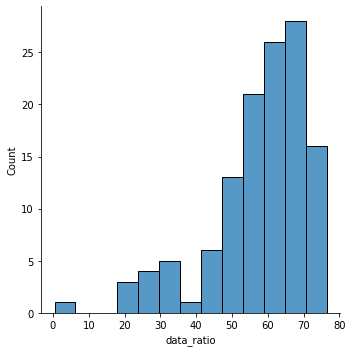

In [24]:
sns.displot(df_videos['data_ratio']);

In [25]:
df_videos['data_ratio'].describe().to_frame()

,data_ratio
count,124.00
mean,57.70
std,13.74
min,0.45
25%,52.87
50%,60.92
75%,67.56
max,76.44


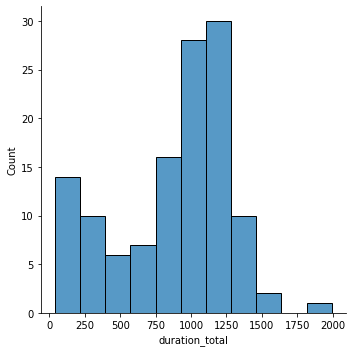

In [26]:
sns.displot(df_videos['duration_total']);

In [27]:
df_videos['duration_total'].describe().to_frame()

,duration_total
count,124.00
mean,885.64
std,411.25
min,38.00
25%,678.00
50%,999.50
75%,"1,163.25"
max,"1,994.00"


## df_words

In [57]:
speaker_interval_ids = df_intervals['interval_id'].tolist()

In [52]:
read_text('214431')

,Word,start_frame,end_frame,frames_count,time
0,or,0,4,4,0.30
1,targeted,4,12,8,0.80
2,regulation,12,21,9,1.40
3,of,21,27,6,1.80
4,abortion,27,34,7,2.30
5,providers,34,42,8,2.80
6,supporters,42,58,16,3.90
7,to,58,63,5,4.20
8,an,63,64,1,4.30
9,earring,64,73,9,4.90


In [61]:
interval_text_status = []
interval_id_to_df_words = {}

for interval_id in tqdm(speaker_interval_ids):
    try:
        df_words = read_text(interval_id)
        interval_id_to_df_words[interval_id] = df_words
        has_text = True
    except ValueError as e:
        has_text = False
    interval_text_status.append([interval_id, has_text])

# Intervals Validity

## Interval PATS Text

### Has Groups (`valid_hd5`)

In [73]:
df_interval_text_status = pd.DataFrame(interval_text_status, columns=['interval_id', 'valid_hd5'])
df_intervals = df_intervals.merge(df_interval_text_status)
display_value_counts(df_intervals['valid_hd5'], 'Valid hd5 group')

,valid_hd5
True,4254
False,375


### Token Frames Duration (`valid_max_token_duration`)

In [83]:
MAX_SECONDS_PER_TOKEN = 4
MAX_FRAMES_THRESHOLD = FRAME_RATE * MAX_SECONDS_PER_TOKEN
print(f'Max allowed frames per token is: {MAX_FRAMES_THRESHOLD} frames (= {MAX_SECONDS_PER_TOKEN} seconds)')

Max allowed frames per token is: 60 frames (= 4 seconds)


In [75]:
UNKNOWN_MAX_FRAMES_PER_TOKEN = -1

def get_max_frames_number_for_token(interval_id):
    try:
        df_tokens = interval_id_to_df_words[interval_id]
        max_token_frames = df_tokens['frames_count'].max()
    except:
        max_token_frames = UNKNOWN_MAX_FRAMES_PER_TOKEN
    return max_token_frames

In [76]:
df_intervals['max_frames_token'] = df_intervals['interval_id'].progress_apply(get_max_frames_number_for_token)

In [81]:
df_intervals.head(n=2)

,Unnamed: 0,Unnamed: 0.1,dataset,duration,end_time,interval_id,speaker,start_time,video_fn,video_link,...,start_time_string,end_time_string,video_id,max_frames_token,valid,valid_max_frames_per_token,valid_duration,valid_single_token_per_frame,video_downloded,valid_hd5
0,43180,43180,dev,12.21,0 days 00:01:10.830000,214428,oliver,0 days 00:00:58.620000,Abortion_Laws_-_Last_Week_Tonight_with_John_Oliver_HBO-DRauXXz6t0Y.webm,http://www.youtube.com/watch?v=DRauXXz6t0Y,...,00:00:58.62,00:01:10.83,DRauXXz6t0Y,88,False,False,False,True,False,True
1,43181,43181,dev,6.14,0 days 00:01:17.110000,214429,oliver,0 days 00:01:10.970000,Abortion_Laws_-_Last_Week_Tonight_with_John_Oliver_HBO-DRauXXz6t0Y.webm,http://www.youtube.com/watch?v=DRauXXz6t0Y,...,00:01:10.97,00:01:17.11,DRauXXz6t0Y,31,False,True,False,True,False,True


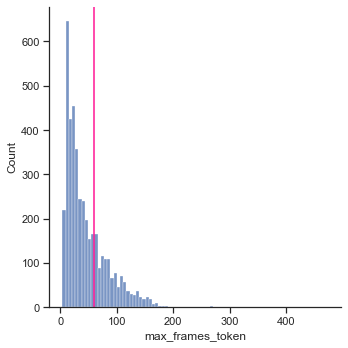

In [103]:
sns.set_style('ticks')
sns.displot(df_intervals[df_intervals['max_frames_token'] != -1]['max_frames_token'])
plt.axvline(MAX_FRAMES_THRESHOLD, color='deeppink');

In [105]:
mask_below_max_frames_limit = (df_intervals['max_frames_token'] < MAX_FRAMES_THRESHOLD)
mask_known_max_frames = (df_intervals['max_frames_token'] != UNKNOWN_MAX_FRAMES_PER_TOKEN) 

df_intervals['valid_max_token_duration'] = mask_below_max_frames_limit & mask_known_max_frames
display_value_counts(df_intervals['valid_max_token_duration'], 'Valid Token Duration')

,valid_max_token_duration
True,3077
False,1552


### Multiple Words Per Frame (`valid_single_token_per_frame`)

In [115]:
df_tokens = read_text('101204')
printmd(f'**Video path**: {resolve_interval_video_path("101204")}')
printmd(f'**Text path**: {resolve_interval_text_path("101204")}')
print(f'Start token unique: {df_tokens["start_frame"].is_unique}')
df_tokens[24:40]

**Video path**: /Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/5d667Bb_iYA/101204/101204.mp4

**Text path**: /Users/staveshemesh/Projects/PATS_DATA/Processed/oliver/data/processed/oliver/101204.h5

Start token unique: False


,Word,start_frame,end_frame,frames_count,time
24,out,117,120,3,8.00
25,me,120,123,3,8.20
26,on,123,123,0,8.20
27,so,123,127,4,8.50
28,too,127,130,3,8.70
29,should,130,136,6,9.10
30,gay,136,141,5,9.40
31,people,141,144,3,9.60
32,be,144,147,3,9.80
33,discriminated,147,147,0,9.80


In [120]:
MAX_TOKENS_PER_FRAME_LIMIT = 2 # allow not more two tokens with the same start frame

def valid_single_frame_tokens_count(interval_id):
    df_tokens = interval_id_to_df_words.get(interval_id)
    if df_tokens is None:
        return False
    max_tokens_per_frame = df_tokens['start_frame'].value_counts().max()
    return max_tokens_per_frame <= MAX_TOKENS_PER_FRAME_LIMIT

In [121]:
df_intervals['valid_single_token_per_frame'] = df_intervals['interval_id'].progress_apply(valid_single_frame_tokens_count)

In [122]:
display_value_counts(df_intervals['valid_single_token_per_frame'], f'Max of {MAX_TOKENS_PER_FRAME_LIMIT} tokens per frame')

,valid_single_token_per_frame
True,4062
False,567


### Frame Count (`valid_frames_count`)

In [140]:
def valid_interval_frame_count(interval_id, duration):
    df_tokens = interval_id_to_df_words.get(interval_id)
    if df_tokens is None:
        return False
    total_frames = df_tokens['end_frame'].max()
    max_tokens_per_frame = df_tokens['start_frame'].value_counts().max()
    lower_bound = (duration - 2) * FRAME_RATE
    upper_bound = (duration + 1) * FRAME_RATE
    is_valid = lower_bound <= total_frames <= upper_bound
    debug_symbol = '✓' if is_valid else '✗'
    if interval_id in df_intervals['interval_id'][:10].tolist():
        print(debug_symbol, interval_id, round(lower_bound, 2), total_frames, round(upper_bound, 2))
    return lower_bound <= total_frames <= upper_bound

In [141]:
df_intervals['valid_frames_count'] = df_intervals[['interval_id', 'duration']].progress_apply(lambda x: valid_interval_frame_count(*x), axis=1)

✓ 214428 153.18 184 198.18
✓ 214429 62.09 93 107.09
✗ 214430 1506.54 1482 1551.54
✓ 214431 73.1 104 118.1
✓ 214433 212.24 241 257.24
✓ 214434 368.4 396 413.4
✓ 214435 70.1 101 115.1
✓ 214436 61.09 92 106.09
✓ 214438 1164.19 1190 1209.19
✗ 214439 124.15 123 169.15



In [132]:
display_value_counts(df_intervals['valid_frames_count'], f'Frame Count = Frame Rate * Seconds')

,valid_frames_count
False,3916
True,713


In [137]:
read_text('214439')

,Word,start_frame,end_frame,frames_count,time
0,restrictions,0,8,8,0.50
1,on,8,8,0,0.50
2,Old,8,11,3,0.70
3,clinics,11,19,8,1.30
4,pictures,19,22,3,1.50
5,of,22,23,1,1.50
6,Kum,23,28,5,1.90
7,&,28,29,1,1.90
8,Go's,29,32,3,2.10
9,now,32,35,3,2.30


## Interval Video

### Total Duration (`valid_duration`)

In [170]:
MIN_DURATION_SECS_THRESHOLD = 4

In [171]:
df_intervals.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'dataset', 'duration', 'end_time',
       'interval_id', 'speaker', 'start_time', 'video_fn', 'video_link',
       'org_start_time', 'org_end_time', 'start_time_string',
       'end_time_string', 'video_id', 'max_frames_token', 'valid',
       'valid_duration', 'valid_single_token_per_frame', 'video_downloded',
       'valid_hd5', 'valid_max_token_duration', 'valid_frames_count'],
      dtype='object')

In [172]:
df_intervals['valid_duration'] = MIN_DURATION_SECS_THRESHOLD < df_intervals['duration']

In [173]:
display_value_counts(df_intervals['valid_duration'], f'Duration > {MIN_DURATION_SECS_THRESHOLD} seconds')

,valid_duration
True,3499
False,1130


## Finalize Valid

In [174]:
df_intervals.columns[df_intervals.columns.str.contains('valid_')].tolist()

['valid_duration',
 'valid_single_token_per_frame',
 'valid_hd5',
 'valid_max_token_duration',
 'valid_frames_count']

In [175]:
df_intervals.drop('valid_max_frames_per_token', axis=1, errors='ignore', inplace=True)

In [176]:
COLS_VALID = [
    'valid_duration',
    'valid_single_token_per_frame',
    'valid_hd5',
    'valid_max_token_duration',
    'valid_frames_count'
]

In [177]:
total_intervals = len(df_intervals)
df_validity_summary = df_intervals[COLS_VALID].sum().to_frame().rename(columns={0: 'records'})
df_validity_summary['%records'] = df_validity_summary['records'] / total_intervals * 100
df_validity_summary

,records,%records
valid_duration,3499,75.59
valid_single_token_per_frame,4062,87.75
valid_hd5,4254,91.90
valid_max_token_duration,3077,66.47
valid_frames_count,4076,88.05


In [184]:
df_intervals['valid'] = df_intervals[COLS_VALID].all(axis=1)
display_value_counts(df_intervals['valid'], 'Valid Intervals')

,valid
False,2511
True,2118


In [186]:
df_validity_summary = df_intervals[['valid'] + COLS_VALID].sum().to_frame().rename(columns={0: 'records'})
df_validity_summary['%records'] = df_validity_summary['records'] / total_intervals * 100
df_validity_summary

,records,%records
valid,2118,45.76
valid_duration,3499,75.59
valid_single_token_per_frame,4062,87.75
valid_hd5,4254,91.90
valid_max_token_duration,3077,66.47
valid_frames_count,4076,88.05


In [246]:
df_intervals[['valid'] + COLS_VIEW + COLS_VALID].head(n=2)

,valid,speaker,interval_id,duration,start_time_string,end_time_string,video_link,valid_duration,valid_single_token_per_frame,valid_hd5,valid_max_token_duration,valid_frames_count
0,False,oliver,214428,12.21,00:00:58.62,00:01:10.83,http://www.youtube.com/watch?v=DRauXXz6t0Y,True,True,True,False,True
1,True,oliver,214429,6.14,00:01:10.97,00:01:17.11,http://www.youtube.com/watch?v=DRauXXz6t0Y,True,True,True,True,True


# Download Data

In [194]:
os.makedirs(OUTPUT_DIR)

In [195]:
printmd(f'{TAB}**/{TIMESTR}** → mkdir {OUTPUT_DIR}..')

&nbsp;&nbsp;&nbsp;&nbsp;**/20210418_005318** → mkdir /Users/staveshemesh/Projects/shstav2/token_voken/data/20210418_005318/dataframes..

## df_intervals.to_csv

In [204]:
df_intervals.drop('Unnamed: 0.1', axis=1, inplace=True)

In [3]:
COLS_OUTPUT = [
    # core
    'speaker', 'video_id', 'interval_id', 'valid',
    # features
    'duration', 'start_time_string',  'end_time_string',
    'video_link', 'video_fn',
    'start_time', 'end_time',
    'org_start_time', 'org_end_time',
    # validity
    'max_frames_token',
    'valid_duration', 'valid_single_token_per_frame', 'video_downloded', 'valid_hd5',
    'valid_max_token_duration', 'valid_frames_count'
]

In [232]:
len(df_intervals.columns), len(COLS_OUTPUT)

(20, 20)

In [235]:
df_intervals = df_intervals[COLS_OUTPUT]
df_intervals.head(n=2)

,speaker,video_id,interval_id,valid,duration,start_time_string,end_time_string,video_link,video_fn,start_time,end_time,org_start_time,org_end_time,max_frames_token,valid_duration,valid_single_token_per_frame,video_downloded,valid_hd5,valid_max_token_duration,valid_frames_count
0,oliver,DRauXXz6t0Y,214428,False,12.21,00:00:58.62,00:01:10.83,http://www.youtube.com/watch?v=DRauXXz6t0Y,Abortion_Laws_-_Last_Week_Tonight_with_John_Oliver_HBO-DRauXXz6t0Y.webm,0 days 00:00:58.620000,0 days 00:01:10.830000,0 days 00:00:58.620000,0 days 00:01:10.830000,88,True,True,False,True,False,True
1,oliver,DRauXXz6t0Y,214429,True,6.14,00:01:10.97,00:01:17.11,http://www.youtube.com/watch?v=DRauXXz6t0Y,Abortion_Laws_-_Last_Week_Tonight_with_John_Oliver_HBO-DRauXXz6t0Y.webm,0 days 00:01:10.970000,0 days 00:01:17.110000,0 days 00:01:10.970000,0 days 00:01:17.110000,31,True,True,False,True,True,True


In [241]:
intervals_output_path = os.path.join(OUTPUT_DIR, f'df_intervals_{SPEAKER_NAME}.csv')
printmd(f'{TAB}**/{TIMESTR}** → df_intervals {intervals_output_path}')
df_intervals.to_csv(intervals_output_path, index=False, header=True)

&nbsp;&nbsp;&nbsp;&nbsp;**/20210418_005318** → df_intervals /Users/staveshemesh/Projects/shstav2/token_voken/data/20210418_005318/dataframes/df_intervals_oliver.csv